In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW1')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
# torch and torchvision imports
import torch
import torchvision

# Download MNIST
torchvision.datasets.MNIST('.', download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
batch_size_train=64
batch_size_test=1
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


tensor(3)
torch.Size([1000, 1, 28, 28])


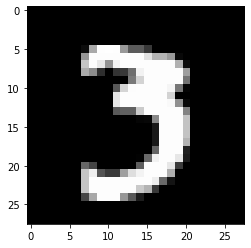

In [ ]:
import matplotlib.pyplot as plt
for idx, data in enumerate(test_loader):
  image,label=data
  plt.imshow(image[idx][0].cpu().data,cmap='gray',)
  if(idx==5):
    print(label[idx])
    print(image.shape)
    break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self): 
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 5,padding=(2,2)),         
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  
            nn.Conv2d(32, 32, 5,padding=(2,2)),         
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),         
            nn.Conv2d(32, 64, 5,padding=(2,2)),         
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)                
        )
     
        self.classifier = nn.Sequential(
            nn.Linear(64*3*3, 64),        
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,10)           
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda")
CNNnet=Net()
CNNnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=0.0001,weight_decay=1e-4)

In [ ]:
train_acc=[]
train_acc.append(0)
trainloss=[]
test_acc=[]
test_acc.append(0)
test_loss=[]

In [ ]:
def traintest_model(train_dataloader,test_loader, optimizer, criterion, net):
  net.to(device)
  over_step = 0 
  for epoch in range(10):
    net.train()
    correct=0
    overall_loss = 0
    total = 0
    for idx,(data,target) in enumerate(train_dataloader):
      data,target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = net(data)
      loss = criterion(output,target)
      overall_loss+=loss.item()
      loss.backward()
      optimizer.step()
      over_step+=1
      pred = torch.argmax(output,1)
      correct+=(pred==target).cpu().sum().item()
      train_loss = overall_loss/(idx+1)
      acc = correct/len(train_dataloader.dataset)
    train_loss = overall_loss/(idx+1)
    accuracy = correct/len(train_dataloader.dataset)
    train_acc.append(accuracy)
    trainloss.append(train_loss)
    print(epoch,"Train accuracy",accuracy*100,train_loss)
    with torch.no_grad(): 
      overall_loss = 0
      correct_values=0
      overall_loss=0
      instances=0
      avg_loss=0
      for idx,data in enumerate(test_loader):
        image,label=data
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        Y_pred=net(image)
        loss = criterion(Y_pred,label)
        overall_loss += loss.item()
        predicted_value=torch.argmax(Y_pred,1)
        instances += image.size(0)
        correct_values+=(predicted_value == label).sum().item()
      testaccuracy = correct_values /len(test_loader.dataset)
      avg_loss = overall_loss /idx+1
      test_acc.append(testaccuracy)
      test_loss.append(avg_loss)
      print("Test accuracy",testaccuracy*100,avg_loss)

In [ ]:
traintest_model(train_loader,test_loader, optimizer, criterion, CNNnet)

0 Train accuracy 94.80166666666666 0.4761288022356374
Test accuracy 98.59 1.1669186237785552
1 Train accuracy 98.63 0.10936506850712462
Test accuracy 98.95 1.0742327732344468
2 Train accuracy 99.065 0.05628283510504882
Test accuracy 99.19 1.0455621919698186
3 Train accuracy 99.26166666666667 0.037668903889472104
Test accuracy 99.22999999999999 1.0347003042697906
4 Train accuracy 99.39666666666666 0.027669625193960885
Test accuracy 99.26 1.0311660652773247
5 Train accuracy 99.565 0.02070803403246727
Test accuracy 99.24 1.0290849622752931
6 Train accuracy 99.55166666666668 0.018304758343293565
Test accuracy 99.31 1.0256035493479834
7 Train accuracy 99.61166666666666 0.01559663561372849
Test accuracy 99.37 1.0226245378661487
8 Train accuracy 99.72666666666666 0.012034986283072133
Test accuracy 99.27 1.0251252537386284
9 Train accuracy 99.72333333333333 0.011486298948484682
Test accuracy 99.39 1.0241980529907677


In [ ]:
epoch=[]
for i in range(10):
  epoch.append(i)
print(epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


**ACCURACY= CORRECT PREDICTIONS/TOTAL**

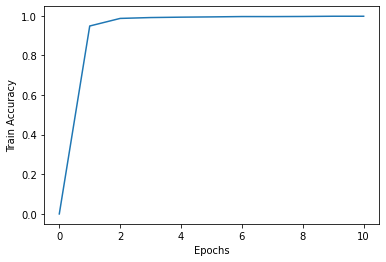

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,train_acc)
plt.ylabel('Train Accuracy')
plt.xlabel('Epochs')
plt.show()

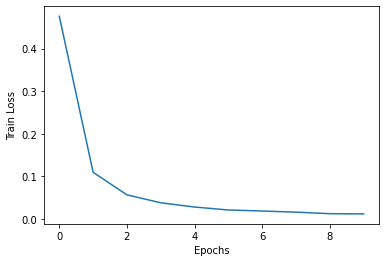

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,trainloss)
plt.ylabel('Train Loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,test_acc)
plt.ylabel('Test Accuracy')
plt.xlabel('Epochs')
plt.show()

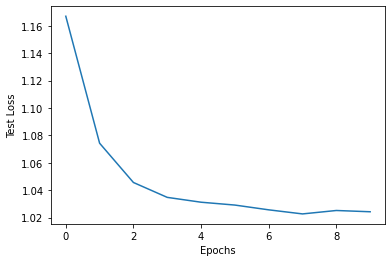

In [ ]:
import matplotlib.pyplot as plt
plt.plot(epoch,test_loss)
plt.ylabel('Test Loss')
plt.xlabel('Epochs')
plt.show()

# **ADVERSARIAL ATTACKS (FGSM)**

In [ ]:
device = torch.device("cuda")
CNNnet=Net()
CNNnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=0.0001,weight_decay=1e-4)
torch.manual_seed(2)

In [ ]:
def train_model(train_dataloader, optimizer, criterion, net):
  net.to(device)
  over_step = 0 
  for epoch in range(4):
    net.train()
    correct=0
    overall_loss = 0
    total = 0
    for idx,(data,target) in enumerate(train_dataloader):
      data,target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = net(data)
      loss = criterion(output,target)
      overall_loss+=loss.item()
      loss.backward()
      optimizer.step()
      over_step+=1
      pred = torch.argmax(output,1)
      correct+=(pred==target).cpu().sum().item()
      train_loss = overall_loss/(idx+1)
      acc = correct/len(train_dataloader.dataset)
    train_loss = overall_loss/(idx+1)
    accuracy = correct/len(train_dataloader.dataset)
    print(epoch,"Train accuracy",accuracy*100,train_loss)

In [ ]:
train_model(train_loader, optimizer, criterion, CNNnet)

0 Train accuracy 94.88499999999999 0.47696327568212554
1 Train accuracy 98.66166666666668 0.10648742540558773
2 Train accuracy 99.05833333333334 0.05453303970519636
3 Train accuracy 99.29166666666667 0.03689008650344127


# **UNTARGETED ATTACKS**

In [ ]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=1, shuffle=True)

In [ ]:
def fgsm(X,net,y,epsilon):
  delta = torch.zeros_like(X,requires_grad=True)
  output = net(X+delta)
  loss = criterion(output,y)
  net.zero_grad()
  loss.backward()
  I_new = torch.clamp(X + torch.clamp(epsilon*delta.grad.detach().sign(),min=0),-1,1)
  return I_new

In [ ]:
target_list=[]
img_adv_list=[]

Ground truth-  6
Prediction-  6
Confidence-  99.84362721443176
Input Image: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


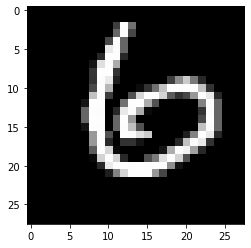

Prediction-  6
Confidence-  99.84362721443176
Prediction-  6
Confidence-  99.71760511398315
Prediction-  6
Confidence-  99.61200952529907
Prediction-  6
Confidence-  99.46016073226929
Prediction-  6
Confidence-  99.2334246635437
Prediction-  6
Confidence-  98.87893199920654
Prediction-  6
Confidence-  98.30575585365295
Prediction-  6
Confidence-  97.38136529922485
Prediction-  6
Confidence-  96.02476358413696
Prediction-  6
Confidence-  93.94749999046326
Prediction-  6
Confidence-  90.72188138961792
Prediction-  6
Confidence-  85.48741340637207
Prediction-  6
Confidence-  77.76142954826355
Prediction-  6
Confidence-  67.34979152679443
Prediction-  6
Confidence-  53.43826413154602
Prediction-  8
Confidence-  57.329946756362915
Prediction-  8
Confidence-  71.11766934394836
Prediction-  8
Confidence-  81.81089758872986
Prediction-  8
Confidence-  88.62659335136414
Prediction-  8
Confidence-  92.97326803207397
Adverserial Image: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


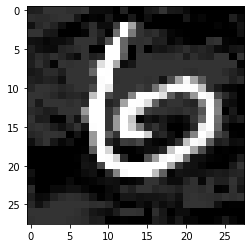

Ground truth-  1
Prediction-  1
Confidence-  98.57315421104431
Input Image: 


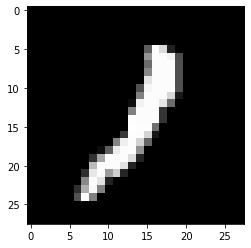

Prediction-  1
Confidence-  98.57315421104431
Prediction-  1
Confidence-  96.17080092430115
Prediction-  1
Confidence-  93.43388080596924
Prediction-  1
Confidence-  87.9831850528717
Prediction-  1
Confidence-  77.04757452011108
Prediction-  1
Confidence-  59.11087989807129
Prediction-  9
Confidence-  47.0910906791687
Prediction-  9
Confidence-  65.12649059295654
Prediction-  9
Confidence-  78.08045744895935
Prediction-  9
Confidence-  86.19557619094849
Prediction-  9
Confidence-  90.65443873405457
Adverserial Image: 


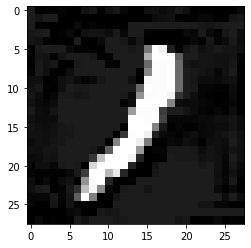

Ground truth-  5
Prediction-  5
Confidence-  99.52291250228882
Input Image: 


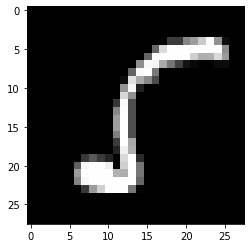

Prediction-  5
Confidence-  99.52291250228882
Prediction-  5
Confidence-  98.36010336875916
Prediction-  5
Confidence-  96.72243595123291
Prediction-  5
Confidence-  93.0911660194397
Prediction-  5
Confidence-  85.62682867050171
Prediction-  5
Confidence-  70.03244161605835
Prediction-  5
Confidence-  44.65411603450775
Prediction-  8
Confidence-  66.41888618469238
Prediction-  8
Confidence-  82.55038857460022
Prediction-  8
Confidence-  91.12801551818848
Adverserial Image: 


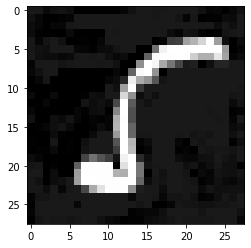

Ground truth-  1
Prediction-  1
Confidence-  72.5372314453125
Input Image: 


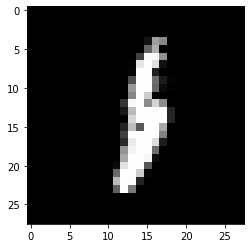

Prediction-  1
Confidence-  72.5372314453125
Prediction-  1
Confidence-  46.337103843688965
Prediction-  8
Confidence-  34.83165204524994
Prediction-  8
Confidence-  48.52716028690338
Prediction-  8
Confidence-  62.46137022972107
Prediction-  8
Confidence-  73.77201318740845
Prediction-  8
Confidence-  84.31259989738464
Prediction-  8
Confidence-  91.24565124511719
Adverserial Image: 


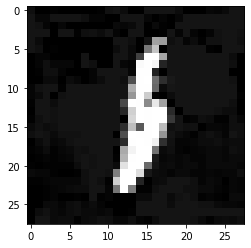

Ground truth-  3
Prediction-  3
Confidence-  99.58651065826416
Input Image: 


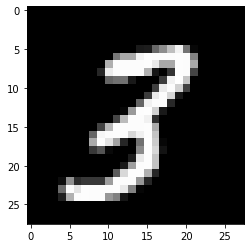

Prediction-  3
Confidence-  99.58651065826416
Prediction-  3
Confidence-  99.15266633033752
Prediction-  3
Confidence-  98.729008436203
Prediction-  3
Confidence-  98.00915122032166
Prediction-  3
Confidence-  96.57036662101746
Prediction-  3
Confidence-  93.61736178398132
Prediction-  3
Confidence-  87.902170419693
Prediction-  3
Confidence-  77.72345542907715
Prediction-  3
Confidence-  63.400113582611084
Prediction-  3
Confidence-  46.994251012802124
Prediction-  8
Confidence-  42.40701198577881
Prediction-  8
Confidence-  55.661189556121826
Prediction-  8
Confidence-  67.8348183631897
Prediction-  8
Confidence-  79.36617732048035
Prediction-  8
Confidence-  87.26837635040283
Prediction-  8
Confidence-  92.4670934677124
Adverserial Image: 


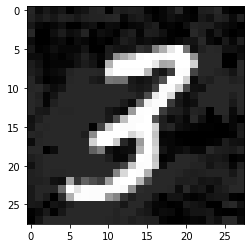

Ground truth-  5
Prediction-  5
Confidence-  99.83391761779785
Input Image: 


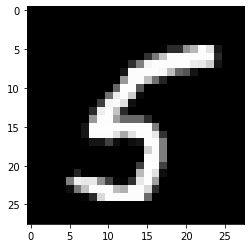

Prediction-  5
Confidence-  99.83391761779785
Prediction-  5
Confidence-  99.47367310523987
Prediction-  5
Confidence-  99.00952577590942
Prediction-  5
Confidence-  98.019939661026
Prediction-  5
Confidence-  95.7195520401001
Prediction-  5
Confidence-  90.1746928691864
Prediction-  5
Confidence-  77.65808701515198
Prediction-  5
Confidence-  56.533294916152954
Prediction-  8
Confidence-  45.676180720329285
Prediction-  8
Confidence-  63.88702392578125
Prediction-  8
Confidence-  75.63368678092957
Prediction-  8
Confidence-  82.27455019950867
Prediction-  8
Confidence-  86.93757057189941
Prediction-  8
Confidence-  90.41162729263306
Adverserial Image: 


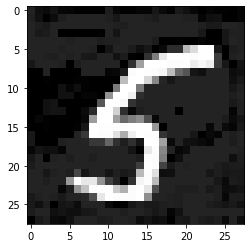

Ground truth-  7
Prediction-  7
Confidence-  99.84939098358154
Input Image: 


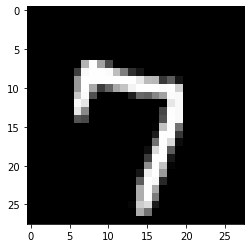

Prediction-  7
Confidence-  99.84939098358154
Prediction-  7
Confidence-  99.65103268623352
Prediction-  7
Confidence-  99.4574785232544
Prediction-  7
Confidence-  99.13051128387451
Prediction-  7
Confidence-  98.53746891021729
Prediction-  7
Confidence-  97.24190831184387
Prediction-  7
Confidence-  94.15633082389832
Prediction-  7
Confidence-  86.48754954338074
Prediction-  7
Confidence-  67.07754135131836
Prediction-  8
Confidence-  49.892833828926086
Prediction-  8
Confidence-  74.96414184570312
Prediction-  8
Confidence-  88.82858157157898
Prediction-  8
Confidence-  95.14327049255371
Adverserial Image: 


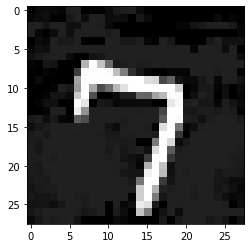

Ground truth-  6
Prediction-  6
Confidence-  97.05990552902222
Input Image: 


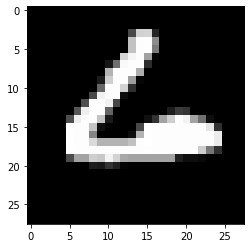

Prediction-  6
Confidence-  97.05990552902222
Prediction-  6
Confidence-  94.13466453552246
Prediction-  6
Confidence-  91.77217483520508
Prediction-  6
Confidence-  87.92945146560669
Prediction-  6
Confidence-  82.43409395217896
Prediction-  6
Confidence-  75.31644701957703
Prediction-  6
Confidence-  66.82470440864563
Prediction-  6
Confidence-  56.5950870513916
Prediction-  6
Confidence-  44.58676874637604
Prediction-  4
Confidence-  50.750184059143066
Prediction-  4
Confidence-  60.553568601608276
Prediction-  4
Confidence-  68.96200776100159
Prediction-  4
Confidence-  75.62382817268372
Prediction-  4
Confidence-  81.44349455833435
Prediction-  4
Confidence-  85.58804392814636
Prediction-  4
Confidence-  88.74496221542358
Prediction-  4
Confidence-  90.95832705497742
Adverserial Image: 


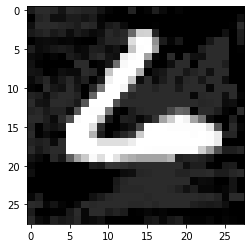

Ground truth-  4
Prediction-  4
Confidence-  99.63769316673279
Input Image: 


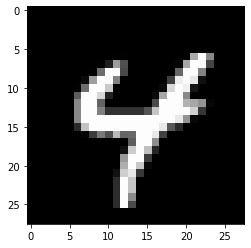

Prediction-  4
Confidence-  99.63769316673279
Prediction-  4
Confidence-  98.99325370788574
Prediction-  4
Confidence-  98.12885522842407
Prediction-  4
Confidence-  96.46300077438354
Prediction-  4
Confidence-  93.00195574760437
Prediction-  4
Confidence-  85.28481125831604
Prediction-  4
Confidence-  70.81904411315918
Prediction-  4
Confidence-  49.378421902656555
Prediction-  8
Confidence-  50.54273009300232
Prediction-  8
Confidence-  69.17580366134644
Prediction-  8
Confidence-  82.30151534080505
Prediction-  8
Confidence-  90.43316841125488
Adverserial Image: 


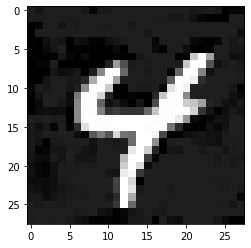

Ground truth-  9
Prediction-  9
Confidence-  99.57606196403503
Input Image: 


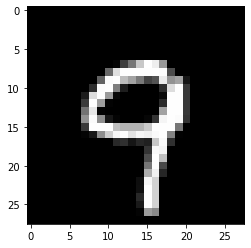

Prediction-  9
Confidence-  99.57606196403503
Prediction-  9
Confidence-  98.89768958091736
Prediction-  9
Confidence-  98.21106791496277
Prediction-  9
Confidence-  96.88720703125
Prediction-  9
Confidence-  94.33189630508423
Prediction-  9
Confidence-  89.06276226043701
Prediction-  9
Confidence-  78.15874814987183
Prediction-  9
Confidence-  60.18267869949341
Prediction-  9
Confidence-  39.55966532230377
Prediction-  8
Confidence-  58.19046497344971
Prediction-  8
Confidence-  75.96619129180908
Prediction-  8
Confidence-  86.86026930809021
Prediction-  8
Confidence-  92.8321897983551
Adverserial Image: 


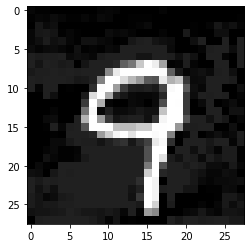

In [ ]:
i=0
import matplotlib.pyplot as plt
device = torch.device("cuda")
CNNnet.to(device)
CNNnet.eval()
count = []
for data,target in test_loader:
  i=i+1
  data,target = data.to(device),target.to(device)
  print("Ground truth- ", target.cpu().item())
  output = F.softmax(CNNnet(data))
  confidence,pred = torch.max(output,1)
  print('Prediction- ',pred.cpu().item() )
  print('Confidence- ' , confidence.cpu().item()*100)
  target_list.append(target)
  print('Input Image: ')
  plt.imshow(data[0][0].cpu().data,cmap='gray',)
  plt.show()

  #Adverserial Image generation
  I_new = fgsm(data,CNNnet,target,0.02)
  output = F.softmax(CNNnet(data))
  confidence,pred = torch.max(output,1)
  print('Prediction- ',pred.cpu().item() )
  print('Confidence- ' , confidence.cpu().item()*100)
  while pred.cpu().item() == target.cpu().item():
    I_new = fgsm(I_new,CNNnet,target,0.02)
    output = F.softmax(CNNnet(I_new))
    confidence,pred = torch.max(output,1)
    print('Prediction- ',pred.cpu().item())
    print('Confidence- ' , confidence.cpu().item()*100)
  while confidence<=0.9:
    I_new = fgsm(I_new,CNNnet,target,0.02)
    output = F.softmax(CNNnet(I_new))
    confidence,pred = torch.max(output,1)
    print('Prediction- ',pred.cpu().item())
    print('Confidence- ' , confidence.cpu().item()*100)
  print('Adverserial Image: ')
  plt.imshow(I_new[0][0].cpu().data,cmap='gray',)
  plt.show()
  Img=I_new[0][0].unsqueeze(0)
  Img=Img.unsqueeze(0)
  img_adv_list.append(Img)
  if i>=10:
    break


# **TARGETED ATTACKS**


In [ ]:
def fgsm_targeted(X,net,y,epsilon,ytarget):
  delta = torch.zeros_like(X,requires_grad=True)
  output = net(X+delta)
  loss = criterion(output,ytarget)
  net.zero_grad()
  loss.backward()
  I_new = torch.clamp(X - torch.clamp(epsilon*delta.grad.detach().sign(),max=0),-1,1)
  return I_new

In [ ]:
ytarget=torch.tensor([4])
ytarget=ytarget.to(device)

Ground truth-  2
Prediction-  2
Confidence-  99.78173971176147
Input Image: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


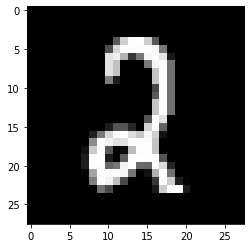

Prediction-  2
Confidence-  99.78173971176147
Prediction-  2
Confidence-  99.4606077671051
Prediction-  2
Confidence-  99.11856055259705
Prediction-  2
Confidence-  98.4204113483429
Prediction-  2
Confidence-  97.15187549591064
Prediction-  2
Confidence-  94.75709795951843
Prediction-  2
Confidence-  89.25836086273193
Prediction-  2
Confidence-  77.61611938476562
Prediction-  2
Confidence-  61.45094037055969
Prediction-  2
Confidence-  47.21512198448181
Prediction-  8
Confidence-  54.334765672683716
Prediction-  8
Confidence-  58.35225582122803
Prediction-  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Confidence-  58.950746059417725
Prediction-  8
Confidence-  59.34206247329712
Prediction-  8
Confidence-  59.09649133682251
Prediction-  8
Confidence-  58.06155800819397
Prediction-  8
Confidence-  56.186097860336304
Prediction-  8
Confidence-  54.5704185962677
Prediction-  8
Confidence-  52.72279977798462
Prediction-  8
Confidence-  50.14985799789429
Prediction-  8
Confidence-  48.26889634132385
Prediction-  8
Confidence-  46.45411670207977
Prediction-  8
Confidence-  44.430550932884216
Prediction-  8
Confidence-  42.590802907943726
Prediction-  8
Confidence-  40.5930370092392
Prediction-  8
Confidence-  40.07091224193573
Prediction-  8
Confidence-  38.519832491874695
Prediction-  8
Confidence-  36.60002946853638
Prediction-  8
Confidence-  35.030773282051086
Prediction-  8
Confidence-  33.07898938655853
Prediction-  8
Confidence-  32.03735947608948
Prediction-  8
Confidence-  30.041542649269104
Prediction-  4
Confidence-  30.311331152915955
Adverserial Image: 


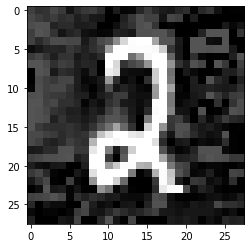

Ground truth-  4
Prediction-  4
Confidence-  86.79913878440857
Input Image: 


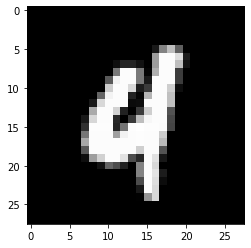

Prediction-  4
Confidence-  86.79913878440857
Adverserial Image: 


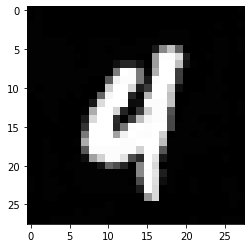

Ground truth-  9
Prediction-  9
Confidence-  99.33779835700989
Input Image: 


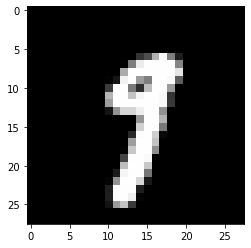

Prediction-  9
Confidence-  99.33779835700989
Prediction-  9
Confidence-  98.50507974624634
Prediction-  9
Confidence-  97.59140610694885
Prediction-  9
Confidence-  95.92544436454773
Prediction-  9
Confidence-  93.02106499671936
Prediction-  9
Confidence-  87.83498406410217
Prediction-  9
Confidence-  80.11310696601868
Prediction-  9
Confidence-  68.65920424461365
Prediction-  9
Confidence-  54.78959083557129
Prediction-  9
Confidence-  41.72434210777283
Prediction-  8
Confidence-  34.83624458312988
Prediction-  8
Confidence-  33.92111659049988
Prediction-  8
Confidence-  31.66024684906006
Prediction-  8
Confidence-  28.494641184806824
Prediction-  4
Confidence-  29.903995990753174
Adverserial Image: 


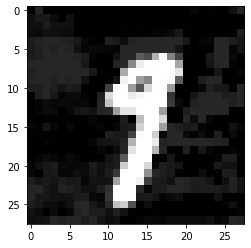

Ground truth-  2
Prediction-  2
Confidence-  93.292635679245
Input Image: 


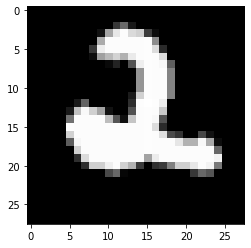

Prediction-  2
Confidence-  93.292635679245
Prediction-  2
Confidence-  87.39243745803833
Prediction-  2
Confidence-  82.95000791549683
Prediction-  2
Confidence-  77.08449959754944
Prediction-  2
Confidence-  69.83176469802856
Prediction-  2
Confidence-  60.87043285369873
Prediction-  2
Confidence-  50.72823166847229
Prediction-  2
Confidence-  39.96201157569885
Prediction-  2
Confidence-  30.510172247886658
Prediction-  7
Confidence-  25.892892479896545
Prediction-  7
Confidence-  28.384900093078613
Prediction-  4
Confidence-  30.820024013519287
Adverserial Image: 


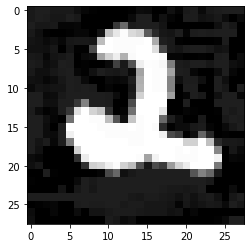

Ground truth-  1
Prediction-  1
Confidence-  97.97479510307312
Input Image: 


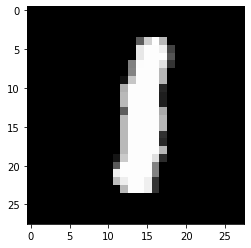

Prediction-  1
Confidence-  97.97479510307312
Prediction-  1
Confidence-  95.13278007507324
Prediction-  1
Confidence-  91.85202121734619
Prediction-  1
Confidence-  86.43108606338501
Prediction-  1
Confidence-  78.48564982414246
Prediction-  1
Confidence-  69.69131231307983
Prediction-  1
Confidence-  60.89791655540466
Prediction-  1
Confidence-  53.24833393096924
Prediction-  1
Confidence-  47.9365348815918
Prediction-  8
Confidence-  46.06062471866608
Prediction-  8
Confidence-  47.46606945991516
Prediction-  8
Confidence-  46.68014645576477
Prediction-  8
Confidence-  45.34713625907898
Prediction-  8
Confidence-  42.71123707294464
Prediction-  8
Confidence-  39.116716384887695
Prediction-  8
Confidence-  34.072479605674744
Prediction-  4
Confidence-  39.25621807575226
Adverserial Image: 


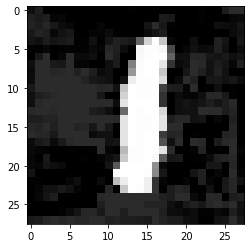

Ground truth-  1
Prediction-  1
Confidence-  99.44885969161987
Input Image: 


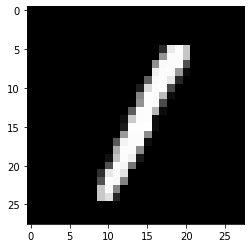

Prediction-  1
Confidence-  99.44885969161987
Prediction-  1
Confidence-  98.94673228263855
Prediction-  1
Confidence-  98.50186705589294
Prediction-  1
Confidence-  97.79301881790161
Prediction-  1
Confidence-  96.5478241443634
Prediction-  1
Confidence-  94.30794715881348
Prediction-  1
Confidence-  90.65828919410706
Prediction-  1
Confidence-  84.59258675575256
Prediction-  1
Confidence-  76.23739838600159
Prediction-  1
Confidence-  65.21241664886475
Prediction-  1
Confidence-  52.364909648895264
Prediction-  1
Confidence-  39.16926085948944
Prediction-  4
Confidence-  33.958324790000916
Adverserial Image: 


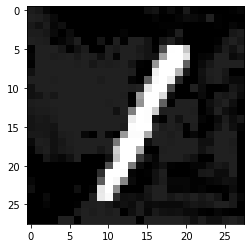

Ground truth-  4
Prediction-  4
Confidence-  99.20138716697693
Input Image: 


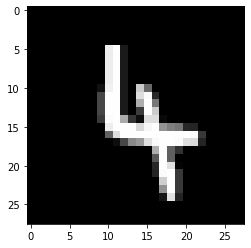

Prediction-  4
Confidence-  99.20138716697693
Adverserial Image: 


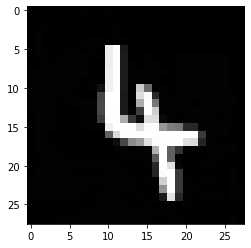

Ground truth-  7
Prediction-  7
Confidence-  99.75587129592896
Input Image: 


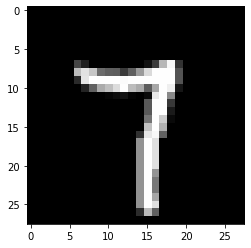

Prediction-  7
Confidence-  99.75587129592896
Prediction-  7
Confidence-  99.52436089515686
Prediction-  7
Confidence-  99.32102560997009
Prediction-  7
Confidence-  99.00147914886475
Prediction-  7
Confidence-  98.46241474151611
Prediction-  7
Confidence-  97.53627181053162
Prediction-  7
Confidence-  95.78115940093994
Prediction-  7
Confidence-  92.52635836601257
Prediction-  7
Confidence-  86.31350994110107
Prediction-  7
Confidence-  75.34642815589905
Prediction-  7
Confidence-  60.973912477493286
Prediction-  7
Confidence-  51.774609088897705
Prediction-  7
Confidence-  45.672112703323364
Prediction-  7
Confidence-  41.95918142795563
Prediction-  7
Confidence-  39.91540968418121
Prediction-  7
Confidence-  39.065879583358765
Prediction-  7
Confidence-  38.05028200149536
Prediction-  7
Confidence-  38.21123242378235
Prediction-  7
Confidence-  37.76564002037048
Prediction-  7
Confidence-  36.568835377693176
Prediction-  7
Confidence-  34.96142327785492
Prediction-  7
Confidence-  3

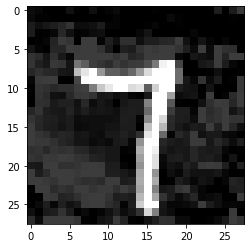

Ground truth-  6
Prediction-  6
Confidence-  99.65904951095581
Input Image: 


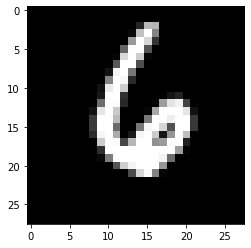

Prediction-  6
Confidence-  99.65904951095581
Prediction-  6
Confidence-  99.4314968585968
Prediction-  6
Confidence-  99.25388693809509
Prediction-  6
Confidence-  98.99667501449585
Prediction-  6
Confidence-  98.59909415245056
Prediction-  6
Confidence-  97.99380898475647
Prediction-  6
Confidence-  96.93694114685059
Prediction-  6
Confidence-  95.15523910522461
Prediction-  6
Confidence-  92.01035499572754
Prediction-  6
Confidence-  86.89191341400146
Prediction-  6
Confidence-  79.44057583808899
Prediction-  6
Confidence-  69.25628185272217
Prediction-  6
Confidence-  57.52403140068054
Prediction-  6
Confidence-  45.04069685935974
Prediction-  4
Confidence-  48.04724454879761
Adverserial Image: 


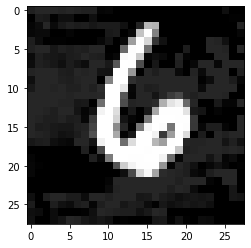

Ground truth-  5
Prediction-  5
Confidence-  99.69859719276428
Input Image: 


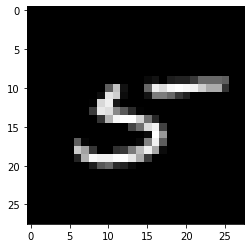

Prediction-  5
Confidence-  99.69859719276428
Prediction-  5
Confidence-  99.2077648639679
Prediction-  5
Confidence-  98.64177703857422
Prediction-  5
Confidence-  97.31957912445068
Prediction-  5
Confidence-  94.35224533081055
Prediction-  5
Confidence-  87.57960200309753
Prediction-  5
Confidence-  74.59176778793335
Prediction-  5
Confidence-  59.58923697471619
Prediction-  5
Confidence-  47.06619679927826
Prediction-  5
Confidence-  40.27819633483887
Prediction-  8
Confidence-  40.22592306137085
Prediction-  8
Confidence-  40.444907546043396
Prediction-  8
Confidence-  39.625513553619385
Prediction-  8
Confidence-  37.79408037662506
Prediction-  8
Confidence-  35.77951192855835
Prediction-  8
Confidence-  34.281137585639954
Prediction-  8
Confidence-  32.71850347518921
Prediction-  4
Confidence-  32.999175786972046
Adverserial Image: 


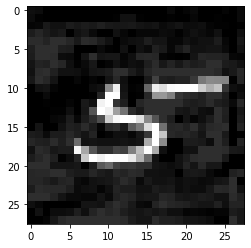

In [ ]:
i=0
import matplotlib.pyplot as plt
device = torch.device("cuda")
CNNnet.to(device)
CNNnet.eval()
count = []
for data,target in test_loader:
  i=i+1
  data,target = data.to(device),target.to(device)
  print("Ground truth- ", target.cpu().item())
  output = F.softmax(CNNnet(data))
  confidence,pred = torch.max(output,1)
  print('Prediction- ',pred.cpu().item() )
  print('Confidence- ' , confidence.cpu().item()*100)
  target_list.append(target)
  print('Input Image: ')
  plt.imshow(data[0][0].cpu().data,cmap='gray',)
  plt.show()

  #Adverserial Image generation
  I_new = fgsm_targeted(data,CNNnet,target,0.02,ytarget)
  output = F.softmax(CNNnet(data))
  confidence,pred = torch.max(output,1)
  print('Prediction- ',pred.cpu().item() )
  print('Confidence- ' , confidence.cpu().item()*100)
  while pred.cpu().item() != ytarget:
    I_new = fgsm_targeted(I_new,CNNnet,target,0.02,ytarget)
    output = F.softmax(CNNnet(I_new))
    confidence,pred = torch.max(output,1)
    print('Prediction- ',pred.cpu().item())
    print('Confidence- ' , confidence.cpu().item()*100)
  print('Adverserial Image: ')
  plt.imshow(I_new[0][0].cpu().data,cmap='gray',)
  plt.show()
  Img=I_new[0][0].unsqueeze(0)
  Img=Img.unsqueeze(0)
  img_adv_list.append(Img)
  if i>=10:
    break


### **Retraining the Network**

In [ ]:
device = torch.device("cuda")
CNNnet=Net()
CNNnet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=0.0001,weight_decay=1e-4)
torch.manual_seed(17)

In [ ]:
train_model(train_loader, optimizer, criterion, CNNnet)

0 Train accuracy 95.5 0.44355089190418023
1 Train accuracy 98.77833333333334 0.10059434630429503
2 Train accuracy 99.18 0.05159268799974625
3 Train accuracy 99.37333333333333 0.034209818285363694


Ground truth-  6
Prediction-  6
Confidence-  66.2740170955658
Input Image: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


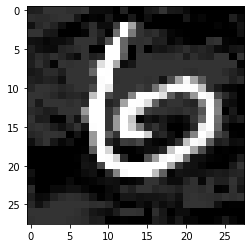

Ground truth-  1
Prediction-  4
Confidence-  32.854169607162476
Input Image: 


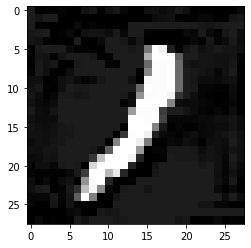

Ground truth-  5
Prediction-  8
Confidence-  80.78929781913757
Input Image: 


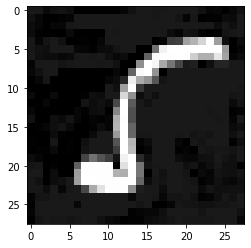

Ground truth-  1
Prediction-  4
Confidence-  56.296730041503906
Input Image: 


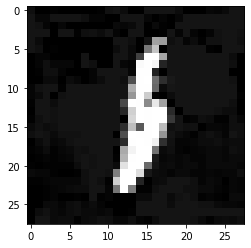

Ground truth-  3
Prediction-  3
Confidence-  51.12531781196594
Input Image: 


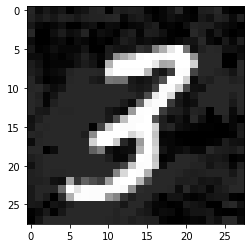

Ground truth-  5
Prediction-  4
Confidence-  31.15217089653015
Input Image: 


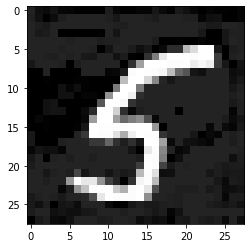

Ground truth-  7
Prediction-  8
Confidence-  34.273916482925415
Input Image: 


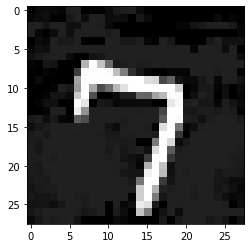

Ground truth-  6
Prediction-  4
Confidence-  89.16478753089905
Input Image: 


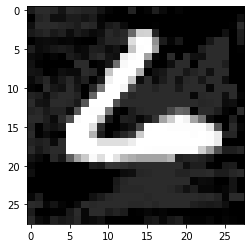

Ground truth-  4
Prediction-  4
Confidence-  98.14815521240234
Input Image: 


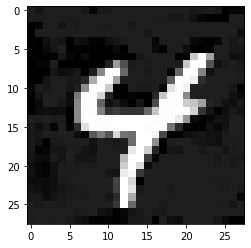

Ground truth-  9
Prediction-  9
Confidence-  69.19253468513489
Input Image: 


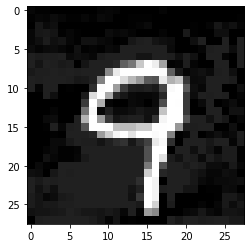

Ground truth-  2
Prediction-  4
Confidence-  59.05848741531372
Input Image: 


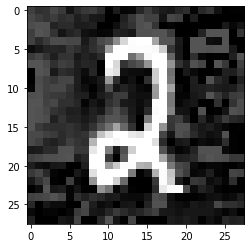

Ground truth-  4
Prediction-  4
Confidence-  98.70840907096863
Input Image: 


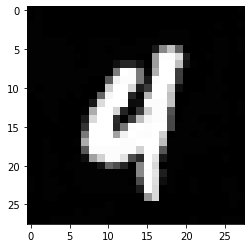

Ground truth-  9
Prediction-  9
Confidence-  47.892504930496216
Input Image: 


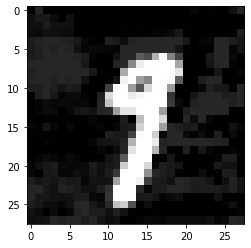

Ground truth-  2
Prediction-  2
Confidence-  69.07830834388733
Input Image: 


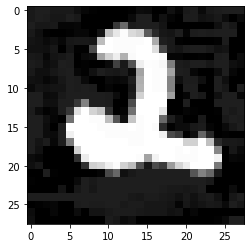

Ground truth-  1
Prediction-  4
Confidence-  75.44956803321838
Input Image: 


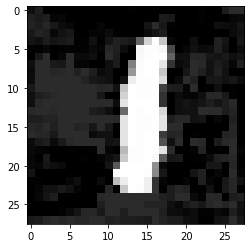

Ground truth-  1
Prediction-  4
Confidence-  74.44939613342285
Input Image: 


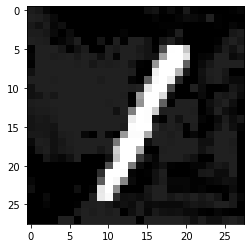

Ground truth-  4
Prediction-  4
Confidence-  98.88924956321716
Input Image: 


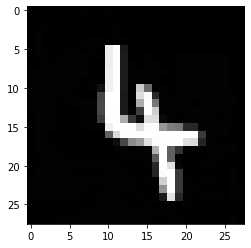

Ground truth-  7
Prediction-  4
Confidence-  42.81095862388611
Input Image: 


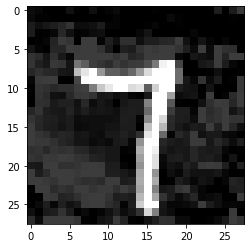

Ground truth-  6
Prediction-  6
Confidence-  92.37715005874634
Input Image: 


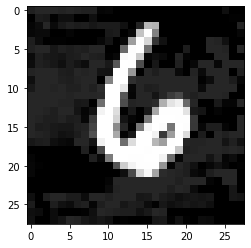

Ground truth-  5
Prediction-  4
Confidence-  59.21730995178223
Input Image: 


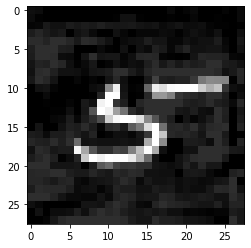

In [ ]:
import matplotlib.pyplot as plt
device = torch.device("cuda")
CNNnet.to(device)
for i in range(20):
  print("Ground truth- ", target_list[i].cpu().item())
  CNNnet.eval()
  output = F.softmax(CNNnet(img_adv_list[i]))
  confidence,pred = torch.max(output,1)
  print('Prediction- ',pred.cpu().item() )
  print('Confidence- ' , confidence.cpu().item()*100)
  print('Input Image: ')
  plt.imshow(img_adv_list[i][0][0].cpu().data,cmap='gray',)
  plt.show()